<a href="https://colab.research.google.com/github/pragatipatel26/DeepFlow/blob/week4/cat_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import h5py
import os
import scipy
from PIL import Image
from scipy import ndimage
uploaded = files.upload()
print(os.listdir())
os.makedirs('datasets', exist_ok=True)  # Create 'datasets' directory
!mv train_catvnoncat.h5 datasets/       # Move the uploaded training file
!mv test_catvnoncat.h5 datasets/        # Move the uploaded test file

def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

#loading the data cat/non-cat
train_set_x_orig,train_set_y,test_set_x_orig,test_set_y,classes=load_dataset()

Saving test_catvnoncat.h5 to test_catvnoncat.h5
Saving train_catvnoncat.h5 to train_catvnoncat.h5
['.config', 'test_catvnoncat.h5', 'train_catvnoncat.h5', 'datasets', 'sample_data']


y = 0, it's a 'non-cat' picture.


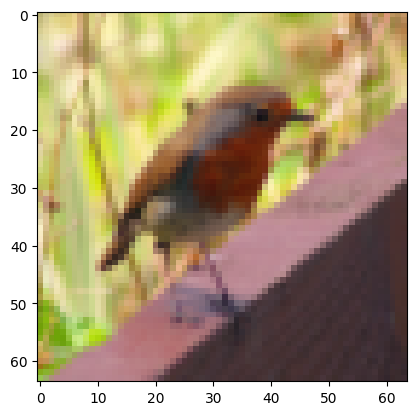

In [ ]:
# Example of a picture
index =10
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[0, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")


In [ ]:
m_train=train_set_x_orig.shape[0];
m_test=test_set_x_orig.shape[0];
num_px=train_set_x_orig.shape[1];
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [ ]:
train_set_x_flatten=train_set_x_orig.reshape(train_set_x_orig.shape[1]*train_set_x_orig.shape[2]*train_set_x_orig.shape[3],train_set_x_orig.shape[0]);
test_set_x_flatten= test_set_x_orig.reshape(test_set_x_orig.shape[1]*test_set_x_orig.shape[2]*test_set_x_orig.shape[3],test_set_x_orig.shape[0]);
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 71 49 38 70]


In [ ]:
#standarizing of data
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

In [ ]:
def sigmoid(z):
  s=1/(1+np.exp(-z))
  return s

initialization

In [ ]:
def initialize_with_zeros(dim):
  w=np.zeros((dim,1))
  b=0
  assert(w.shape == (dim, 1))
  assert(isinstance(b, float) or isinstance(b, int))

  return w, b

forward and backward propagation


In [ ]:
def propagate(w,b,X,Y):
    m=X.shape[1]
    #forward propagation
    A=sigmoid(np.dot(w.T,X)+b)
    cost=np.sum((-np.log(A)*Y+np.log(1-A)*(1-Y)))/m
    #backward propagation
    dw=np.dot(X,(A-Y).T)/m
    db=np.sum(A-Y)/m
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())

    grads = {"dw": dw,
             "db": db}

    return grads, cost

optimization

In [ ]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
  costs=[]
  for i in range(num_iterations):
    grads,cost=propagate(w,b,X,Y)
    dw=grads["dw"]
    db=grads["db"]
    w=w-learning_rate*dw
    b=b-learning_rate*db
    if i % 100 == 0:
      costs.append(cost)
    if print_cost and i % 100 == 0:
      print ("Cost after iteration %i: %f" %(i, cost))
  params = {"w": w,
              "b": b}

  grads = {"dw": dw,
             "db": db}

  return params, grads, costs

prediction

In [ ]:
def predict(w,b,X):
  m=X.shape[1]
  Y_prediction=np.zeros((1,m))
  w=w.reshape(X.shape[0],1)
  A=sigmoid(np.dot(w.T,X)+b)
  for i in range(A.shape[1]):
    if A[0,i]<=0.5:
      Y_prediction[0,i]=0
    else:
      Y_prediction[0,i]=1
  return Y_prediction

model

In [ ]:
def model(  X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
  w,b=initialize_with_zeros(X_train.shape[0])
  parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
  w=parameters["w"]
  b=parameters["b"]
  Y_prediction_test=predict(w,b,X_test)
  Y_prediction_train=predict(w,b,X_train)
  print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
  print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


  d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

  return d

In [ ]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = False)

train accuracy: 91.38755980861244 %
test accuracy: 34.0 %


learning rate is: 0.01
train accuracy: 71.29186602870814 %
test accuracy: 34.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 74.16267942583733 %
test accuracy: 34.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 66.02870813397129 %
test accuracy: 34.0 %

-------------------------------------------------------



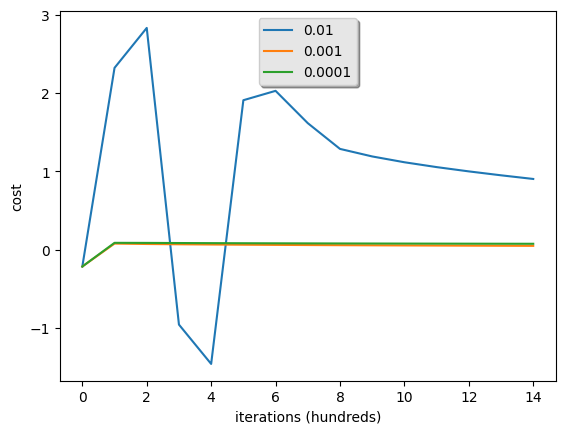

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()